In [12]:
#Creating the data
import random

def generate_duck_probabilities():
    raw_probs = [random.uniform(15, 25) for _ in range(5)]
    total = sum(raw_probs)
    normalized_probs = [round(p/total, 4) for p in raw_probs]
    return normalized_probs

duck_probs = generate_duck_probabilities()
for i,prob in enumerate(duck_probs):
    print(f"Duck {i+1}: {prob*100:.2f}% chance to win")

Duck 1: 20.11% chance to win
Duck 2: 18.46% chance to win
Duck 3: 21.18% chance to win
Duck 4: 24.00% chance to win
Duck 5: 16.25% chance to win


In [13]:
def simulate_duck_race():
    duck_probs = generate_duck_probabilities()
    ducks = ['Duck 1','Duck 2','Duck 3','Duck 4','Duck 5']

    winner = random.choices(ducks, weights=duck_probs, k=1)[0]
    
    return list(zip(ducks, duck_probs)), winner

race_results, winner = simulate_duck_race()
for duck, prob in race_results:
    print(f"{duck}: {prob*100:.2f}% chance to win")
print(f"\n🏁 Winner: {winner}")

Duck 1: 23.19% chance to win
Duck 2: 16.27% chance to win
Duck 3: 20.26% chance to win
Duck 4: 22.98% chance to win
Duck 5: 17.31% chance to win

🏁 Winner: Duck 4


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def show_duck_probabilities_pie(race_results):
    df = pd.DataFrame(race_results, column=['Duck','Win Probability'])

    df['Percent'] = df['Win Probability']*100

    plt.figure(figsize=(6, 6))
    plt.pie(df['Percent'], labels=df['Duck'], autopct='%1.1f%%', startangle=90)
    plt.title("Duck Race Win Probability")
    plt.axis('equal')  # Equal aspect ratio makes the pie circular.
    plt.show()

race_results, winner = simulate_duck_race()
print(f"\nWinner: {winner}")

# Show the pie chart
show_duck_probabilities_pie(race_results)



Winner: Duck 5


TypeError: DataFrame.__init__() got an unexpected keyword argument 'column'

In [ ]:
def simulate_multiple_races(n_races=100):
    all_data = []
    for race_id in range(1, n_races + 1):
        race_results, winner = simulate_duck_race()
        for duck_id, (duck_name, prob) in enumerate(race_results):
            all_data.append({
                'race_id': race_id,
                'duck_id': duck_id,
                'duck_name': duck_name,
                'prob_to_win': prob,
                'winner': duck_name == winner
            })
    return pd.DataFrame(all_data)

df = simulate_multiple_races(100)
print(df.head(100))


    race_id  duck_id duck_name  prob_to_win  winner
0         1        0    Duck 1       0.1667   False
1         1        1    Duck 2       0.2052   False
2         1        2    Duck 3       0.2104   False
3         1        3    Duck 4       0.2385    True
4         1        4    Duck 5       0.1792   False
..      ...      ...       ...          ...     ...
95       20        0    Duck 1       0.1781    True
96       20        1    Duck 2       0.2559   False
97       20        2    Duck 3       0.1890   False
98       20        3    Duck 4       0.2140   False
99       20        4    Duck 5       0.1629   False

[100 rows x 5 columns]


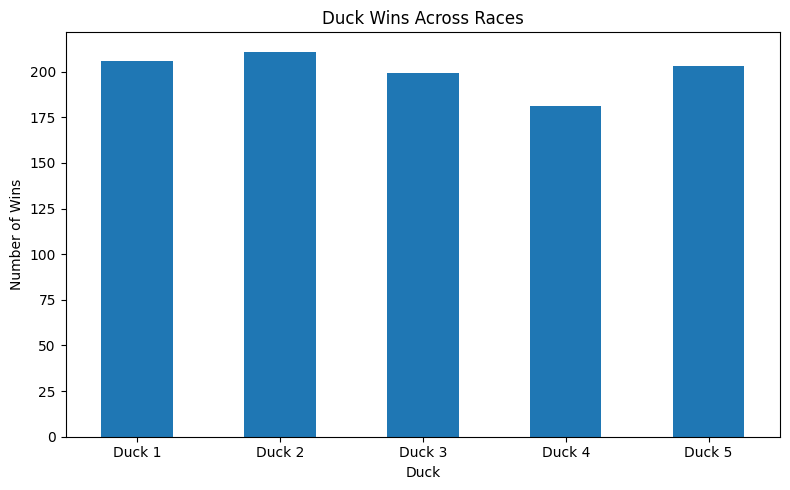

In [ ]:
def plot_duck_win_counts(df):
    # Filter to only winning ducks
    winner_df = df[df['winner'] == True]

    # Count wins per duck
    win_counts = winner_df['duck_name'].value_counts().sort_index()

    # Plot bar chart
    win_counts.plot(kind='bar', figsize=(8, 5))
    plt.title("Duck Wins Across Races")
    plt.xlabel("Duck")
    plt.ylabel("Number of Wins")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Run 500 races
df = simulate_multiple_races(1000)
# Show bar chart of wins
plot_duck_win_counts(df)

In [18]:
def simulate_multiple_races_with_history(n_races=100):
    all_data = []
    win_history = {f'Duck {i+1}': 0 for i in range(5)}

    for race_id in range(1, n_races + 1):
        race_results, winner = simulate_duck_race()

        for duck_id, (duck_name, prob) in enumerate(race_results):
            prior_wins = win_history[duck_name]

            all_data.append({
                'race_id': race_id,
                'duck_id': duck_id,
                'duck_name': duck_name,
                'prob_to_win': prob,
                'prior_wins': prior_wins,
                'winner': duck_name == winner
            })

        # After recording, update winner history
        win_history[winner] += 1

    return pd.DataFrame(all_data)


In [19]:
df = simulate_multiple_races_with_history(1000)

# Features and labels
features = ['duck_id', 'prob_to_win', 'prior_wins']
X = df[features]
y = df['winner']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
def evaluate_race_level_accuracy(df, model):
    correct = 0
    total = df['race_id'].nunique()

    for race_id, group in df.groupby('race_id'):
        X_race = group[['duck_id', 'prob_to_win', 'prior_wins']]
        y_true = group['winner'].values
        y_pred_proba = model.predict_proba(X_race)[:, 1]

        # Pick the duck with the highest predicted win probability
        pred_idx = y_pred_proba.argmax()
        actual_idx = y_true.argmax()

        if pred_idx == actual_idx:
            correct += 1

    print(f"🏁 Race-level prediction accuracy: {correct}/{total} = {correct/total:.2%}")


In [21]:
evaluate_race_level_accuracy(df, model)

🏁 Race-level prediction accuracy: 876/1000 = 87.60%


In [15]:
def run_duck_race_once(model, win_history, race_id):
    # Simulate one race
    race_results, actual_winner = simulate_duck_race()

    # Create race DataFrame
    ducks = []
    for duck_id, (duck_name, prob) in enumerate(race_results):
        prior_wins = win_history.get(duck_name, 0)
        ducks.append({
            'duck_id': duck_id,
            'duck_name': duck_name,
            'prob_to_win': prob,
            'prior_wins': prior_wins
        })

    race_df = pd.DataFrame(ducks)
    features = race_df[['duck_id', 'prob_to_win', 'prior_wins']]

    # Predict with model
    race_df['predicted_win_prob'] = model.predict_proba(features)[:, 1]
    ai_guess = race_df.loc[race_df['predicted_win_prob'].idxmax(), 'duck_name']

    # Display race data
    print(f"\n🏁 Race {race_id}")
    for _, row in race_df.iterrows():
        print(f"{row['duck_name']}: {row['prob_to_win']*100:.2f}% chance, {row['prior_wins']} prior wins")

    print(f"\n🤖 AI predicts: {ai_guess}")

    # User input
    user_guess = input("🎯 Your guess (type a duck name like 'Duck 3'): ").strip()

    # Result
    print(f"\n✅ Actual Winner: {actual_winner}")
    print("🎉 You guessed correctly!" if user_guess == actual_winner else "❌ You were wrong.")
    print("🤖 AI guessed correctly!" if ai_guess == actual_winner else "🤖 AI guessed wrong.")

    # Update win history
    win_history[actual_winner] = win_history.get(actual_winner, 0) + 1

    return win_history



In [16]:

# First create history and race_id
win_history = {f'Duck {i+1}': 0 for i in range(5)}
race_id = 1

# Run one race with terminal input/output
win_history = run_duck_race_once(model, win_history, race_id)


NameError: name 'model' is not defined